# Melbourne Housing Price Prediction  

## Project Idea  
The goal of this project is to predict **house prices in Melbourne** using both property features (rooms, size, year built) and **location features** (suburb, latitude, longitude).  
We will also engineer new features such as **distance to CBD and nearby amenities** to see how location impacts price, and then retrain regression models with these features.  

## Dataset Description  
The dataset contains property sales records in Melbourne with the following key columns:  

- **Suburb, Address** → Location details of the property  
- **Rooms, Bedroom2, Bathroom, Car** → Number of rooms, bedrooms, bathrooms, and car spaces  
- **Type** → Property type (House, Unit, Townhouse, etc.)  
- **Price** → Target variable (property sale price)  
- **Method, SellerG** → Sale method & real estate agent  
- **Date** → Date of sale  
- **Distance** → Distance from Melbourne CBD (in km)  
- **Postcode, CouncilArea, Regionname** → Administrative location info  
- **Landsize, BuildingArea, YearBuilt** → Physical features of the property  
- **Lattitude, Longtitude** → Geographic coordinates (for geospatial features)  
- **Propertycount** → Number of properties in the suburb  

In [28]:
# 1. Import libraries
import pandas as pd
import numpy as np

# 2. Load dataset
df = pd.read_csv("melb_data.csv")

print("Initial shape:", df.shape)
print("Columns:", df.columns.tolist())

# 3. Keeping relevant columns
cols_to_keep = [
    "Suburb", "Rooms", "Type", "Price", "Date", "Distance", "Postcode", 
    "Bedroom2", "Bathroom", "Car", "Landsize", "BuildingArea", 
    "YearBuilt", "CouncilArea", "Lattitude", "Longtitude", 
    "Regionname", "Propertycount"
]
df = df[[c for c in cols_to_keep if c in df.columns]].copy()

# --- minimal fix: standardize lat/lon names ---
df.rename(columns={"Lattitude":"Latitude", "Longtitude":"Longitude"}, inplace=True)

# 4. Handle missing values 
# Drop rows where Price, Latitude, Longitude are missing or invalid
df = df.dropna(subset=["Price", "Latitude", "Longitude"]).copy()
df = df[(df["Price"] > 0) & df["Latitude"].between(-90, 90) & df["Longitude"].between(-180, 180)].copy()

# Light numeric coercion (avoids issues if numbers are stored as strings)
for col in ["BuildingArea", "Landsize", "YearBuilt", "Bedroom2", "Bathroom", "Car", "Propertycount", "Postcode"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Fill BuildingArea and Landsize with median
if "BuildingArea" in df.columns:
    df["BuildingArea"] = df["BuildingArea"].fillna(df["BuildingArea"].median())
if "Landsize" in df.columns:
    df["Landsize"] = df["Landsize"].fillna(df["Landsize"].median())

# Fill YearBuilt with median year
if "YearBuilt" in df.columns:
    df["YearBuilt"] = df["YearBuilt"].fillna(df["YearBuilt"].median())

# >>> Do NOT fill Distance here (you'll replace with OSMnx distances)
# if "Distance" in df.columns:
#     df["Distance"] = df["Distance"].fillna(df["Distance"].median())

# Fill Bedroom2, Bathroom, Car with median
for col in ["Bedroom2", "Bathroom", "Car"]:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())

print("Shape after cleaning:", df.shape)

# === 5. Feature Engineering ===
# Convert Date to year
df["Year"] = pd.to_datetime(df["Date"], errors="coerce").dt.year
df = df.dropna(subset=["Year"]).copy()
df["Year"] = df["Year"].astype(int)

# Age of house (clipped to avoid negatives)
current_year = int(df["Year"].max())
if "YearBuilt" in df.columns:
    df["Age"] = (current_year - df["YearBuilt"]).clip(lower=0)
else:
    df["Age"] = np.nan

# Price per sqm (avoid division by zero)
df["Price_per_sqm"] = df["Price"] / (df["Landsize"].clip(lower=1))

# Rooms to Bathroom ratio
df["Room_Bath_Ratio"] = df["Rooms"] / (df["Bathroom"] + 1)

# === 6. Basic EDA check ===
print(df.describe().T)


Initial shape: (13580, 21)
Columns: ['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG', 'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude', 'Longtitude', 'Regionname', 'Propertycount']
Shape after cleaning: (13580, 18)
                  count          mean            std           min  \
Rooms            5138.0  2.922149e+00       0.968740      1.000000   
Price            5138.0  1.079157e+06  653016.937886  85000.000000   
Distance         5138.0  1.003081e+01       5.779750      0.000000   
Postcode         5138.0  3.106047e+03      90.955374   3000.000000   
Bedroom2         5138.0  2.898988e+00       0.994101      0.000000   
Bathroom         5138.0  1.541067e+00       0.695915      0.000000   
Car              5138.0  1.598093e+00       0.947016      0.000000   
Landsize         5138.0  6.183996e+02    6125.782824      0.000000   
BuildingArea     5138.0  1.363131e+02     119.478592  

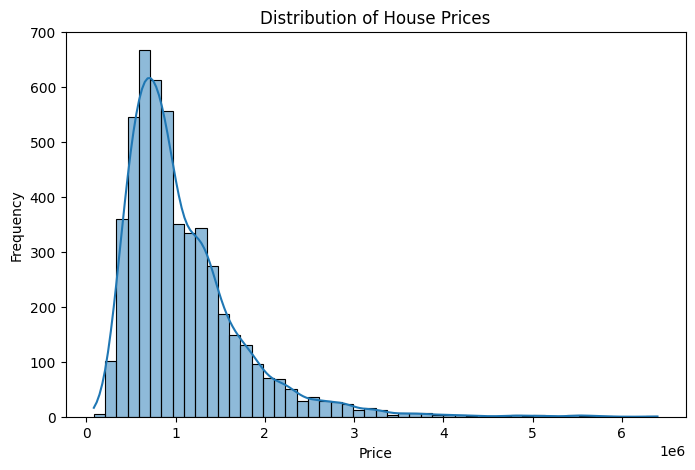

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Distribution of Target Variable (Price)
plt.figure(figsize=(8,5))
sns.histplot(df["Price"], bins=50, kde=True)
plt.title("Distribution of House Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

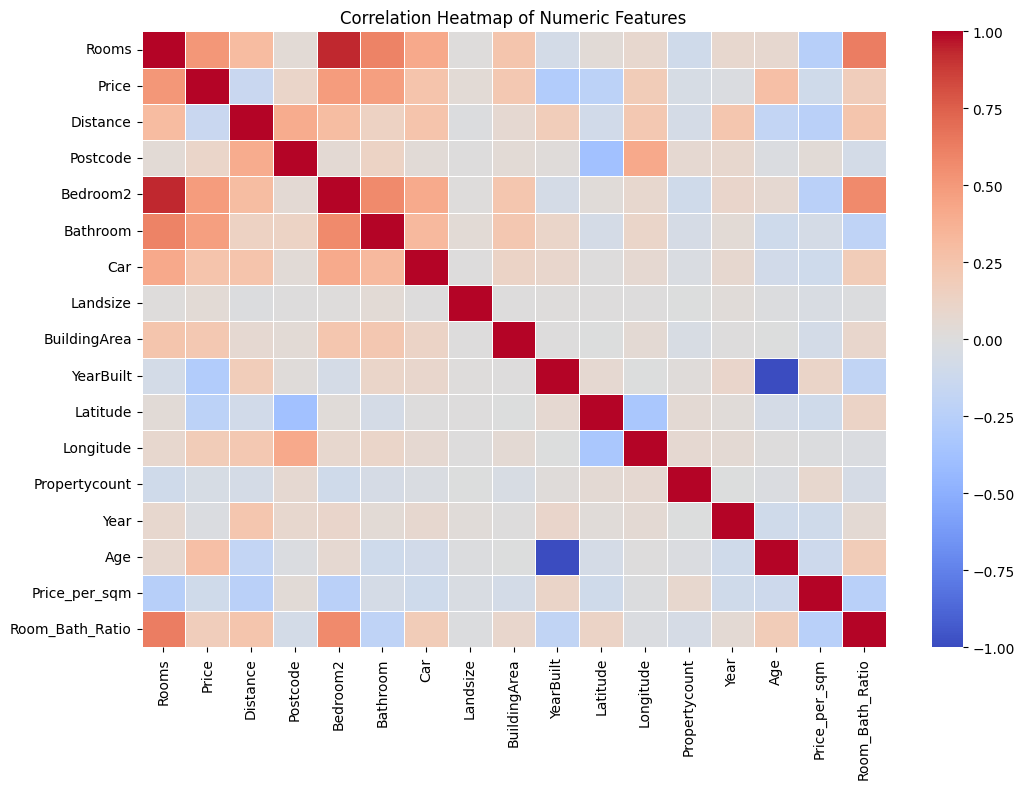

In [30]:
# 2. Correlation Heatmap (numeric variables only)
plt.figure(figsize=(12,8))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

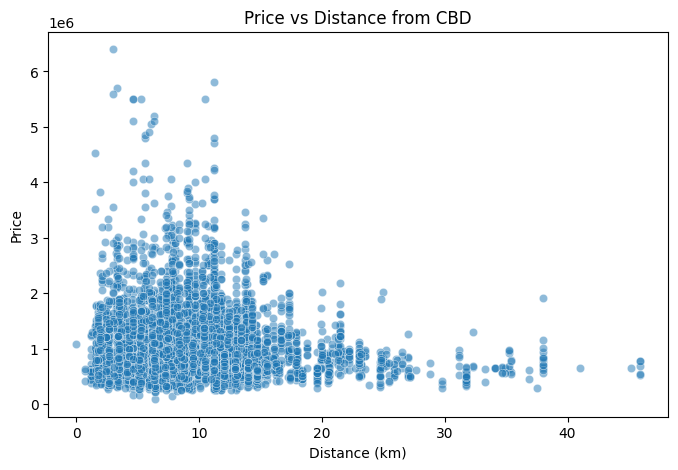

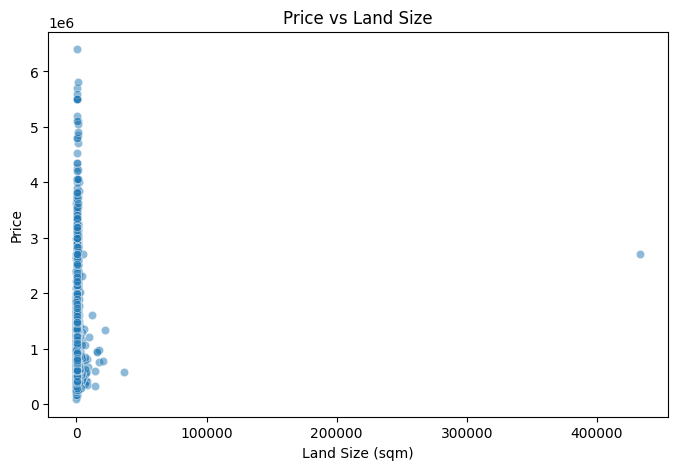

In [31]:
# 3. Scatter Plots
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x="Distance", y="Price", alpha=0.5)
plt.title("Price vs Distance from CBD")
plt.xlabel("Distance (km)")
plt.ylabel("Price")
plt.show()


plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x="Landsize", y="Price", alpha=0.5)
plt.title("Price vs Land Size")
plt.xlabel("Land Size (sqm)")
plt.ylabel("Price")
plt.show()

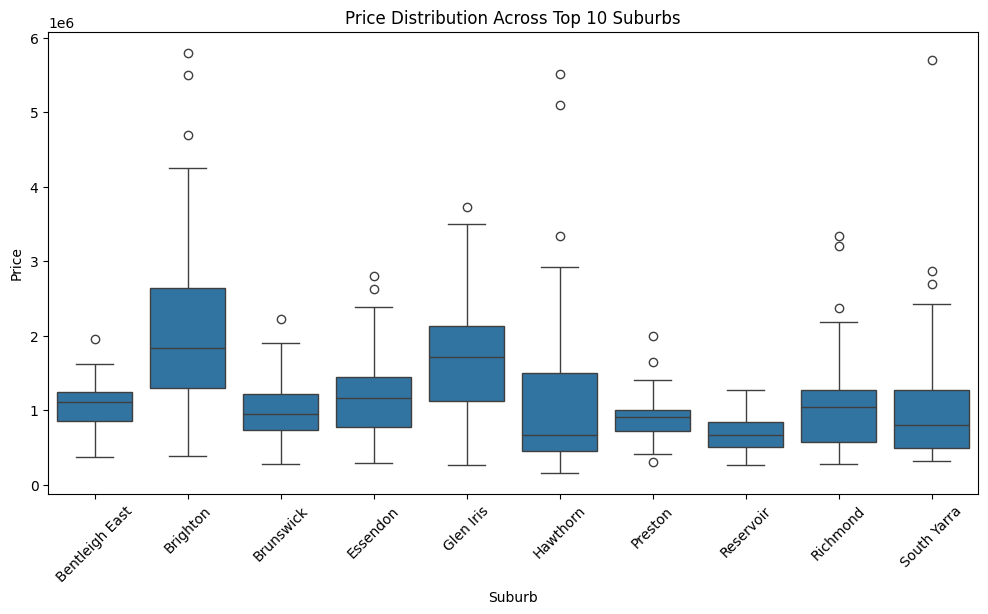

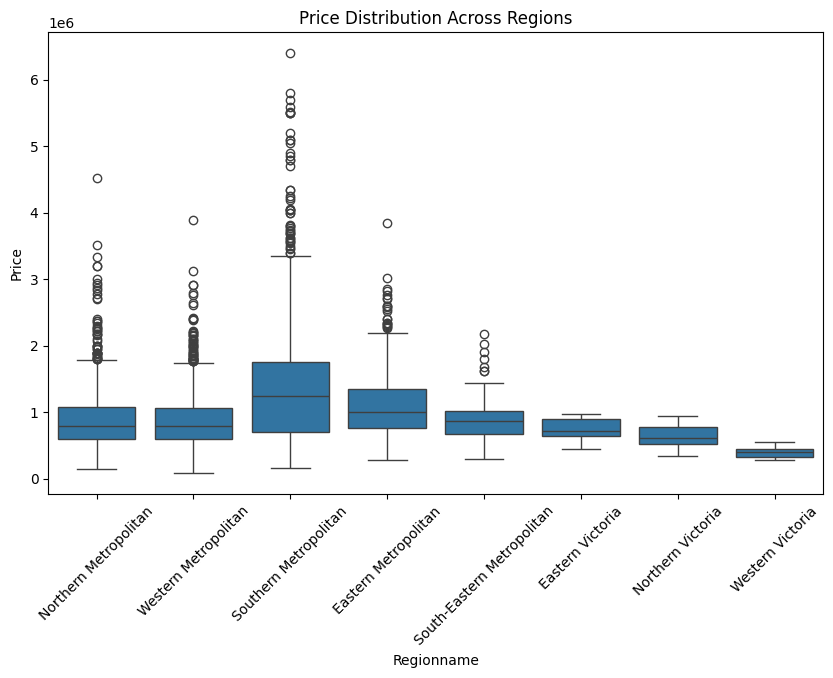

In [32]:
# 4. Boxplots for Categorical Features
plt.figure(figsize=(12,6))
top_suburbs = df["Suburb"].value_counts().head(10).index
sns.boxplot(data=df[df["Suburb"].isin(top_suburbs)], x="Suburb", y="Price")
plt.title("Price Distribution Across Top 10 Suburbs")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(data=df, x="Regionname", y="Price")
plt.title("Price Distribution Across Regions")
plt.xticks(rotation=45)
plt.show()

In [33]:
df["Log_Landsize"] = np.log1p(df["Landsize"])
df["Log_BuildingArea"] = np.log1p(df["BuildingArea"])


In [35]:
# === Install required libraries (run once) ===
# !pip install osmnx geopandas shapely pyproj rtree

import osmnx as ox
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
from scipy.spatial import cKDTree

# === Step 1: Convert houses into GeoDataFrame ===
# (Use standardized column names: Longitude, Latitude)
gdf_houses = gpd.GeoDataFrame(
    df.copy(),
    geometry=gpd.points_from_xy(df["Longitude"], df["Latitude"]),
    crs="EPSG:4326"       # input is lat/lon
).to_crs(epsg=3857)       # convert to meters for distance calcs

# === Step 2: Helper function to add nearest distance + name ===
def add_nearest_distance(gdf_points, place_name, tags, colname, name_col="name"):
    print(f"Fetching {colname} data from OpenStreetMap...")

    # Handle OSMnx version differences
    if hasattr(ox, "features_from_place"):
        pois = ox.features_from_place(place_name, tags)
    else:
        pois = ox.geometries_from_place(place_name, tags)

    if pois.empty:
        print(f"No {colname} found in OSM for {place_name}")
        gdf_points[colname] = np.nan
        gdf_points[colname + "_name"] = None
        return gdf_points

    # Convert to projected CRS in meters; use allow_override for robustness
    if pois.crs is None:
        pois = pois.set_crs(epsg=4326, allow_override=True)
    pois = pois.to_crs(epsg=3857)
    pois["geometry"] = pois.geometry.centroid  # use centroids for polygons/lines

    # KDTree for nearest neighbor search (euclidean in meters)
    poi_xy = np.c_[pois.geometry.x.values, pois.geometry.y.values]
    house_xy = np.c_[gdf_points.geometry.x.values, gdf_points.geometry.y.values]
    tree = cKDTree(poi_xy)
    dists_m, idxs = tree.query(house_xy, k=1)

    # Save distance (km)
    gdf_points[colname] = dists_m / 1000.0

    # Save nearest amenity name if available
    if name_col in pois.columns:
        nearest_names = pois.iloc[idxs][name_col].fillna("Unknown").values
        gdf_points[colname + "_name"] = nearest_names
    else:
        gdf_points[colname + "_name"] = None

    print(f"Added: {colname} (km) + {colname}_name")
    return gdf_points

# === Step 3: Add features for Melbourne ===
place = "Melbourne, Australia"

gdf_houses = add_nearest_distance(gdf_houses, place, {"amenity": "school"}, "dist_school")
gdf_houses = add_nearest_distance(gdf_houses, place, {"amenity": "college"}, "dist_college")
gdf_houses = add_nearest_distance(gdf_houses, place, {"amenity": "university"}, "dist_university")
gdf_houses = add_nearest_distance(gdf_houses, place, {"amenity": ["hospital", "clinic"]}, "dist_hospital")
gdf_houses = add_nearest_distance(gdf_houses, place, {"railway": "station"}, "dist_station")

# === Step 4: Back to pandas DataFrame ===
df = pd.DataFrame(gdf_houses.drop(columns="geometry"))

# === Step 5: Preview results ===
preview_cols = [
    "Suburb", "Price", "Distance", 
    "dist_school", "dist_school_name",
    "dist_college", "dist_college_name",
    "dist_university", "dist_university_name",
    "dist_hospital", "dist_hospital_name",
    "dist_station", "dist_station_name"
]
print("\nPreview with new distance features:")
print(df[[c for c in preview_cols if c in df.columns]].head())

print("\nSummary of new features (km):")
summ_cols = ["dist_school", "dist_college", "dist_university", "dist_hospital", "dist_station"]
print(df[[c for c in summ_cols if c in df.columns]].describe().round(2))


Fetching dist_school data from OpenStreetMap...
Added: dist_school (km) + dist_school_name
Fetching dist_college data from OpenStreetMap...
Added: dist_college (km) + dist_college_name
Fetching dist_university data from OpenStreetMap...
Added: dist_university (km) + dist_university_name
Fetching dist_hospital data from OpenStreetMap...
Added: dist_hospital (km) + dist_hospital_name
Fetching dist_station data from OpenStreetMap...
Added: dist_station (km) + dist_station_name

Preview with new distance features:
       Suburb      Price  Distance  dist_school             dist_school_name  \
0  Abbotsford  1480000.0       2.5     0.910623  Sophia Mundi Steiner School   
1  Abbotsford  1035000.0       2.5     0.635859    Abbotsford Primary School   
2  Abbotsford  1465000.0       2.5     0.507983    Abbotsford Primary School   
3  Abbotsford   850000.0       2.5     1.033918  Clifton Hill Primary School   
4  Abbotsford  1600000.0       2.5     0.594958    Abbotsford Primary School   

   

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

import numpy as np
import pandas as pd

# ================================
# DATA PREP
# ================================
drop_cols = [
    "Date", "dist_school_name","dist_college_name","dist_university_name",
    "dist_hospital_name","dist_station_name", "Log_Price"  # drop leakage cols if present
]
df_model = df.drop(columns=[c for c in drop_cols if c in df.columns]).copy()

target_col = "Price"
cat_cols = ["Suburb", "Type", "CouncilArea", "Regionname", "Postcode"]
cat_cols = [c for c in cat_cols if c in df_model.columns]

# Encode categoricals
for col in cat_cols:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col].astype(str))

# Handle missing values
for col in df_model.columns:
    if df_model[col].dtype == "object":
        df_model[col] = df_model[col].fillna(df_model[col].mode()[0])
    else:
        df_model[col] = df_model[col].fillna(df_model[col].median())

# Features & target (target on log scale!)
X = df_model.drop(columns=[target_col])
y_log = np.log1p(df_model[target_col])   # <-- log target

# Train/Test split
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

# Scale features (for models that need it)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ================================
# EVALUATION FUNCTION
# ================================
def evaluate_price(y_true_log, y_pred_log, name):
    """RMSE/MAE in original Price, R² on log target."""
    y_true = np.expm1(y_true_log)   # back-transform
    y_pred = np.expm1(y_pred_log)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2  = r2_score(y_true_log, y_pred_log)
    return {"Model": name, "RMSE": rmse, "MAE": mae, "R2(log)": r2}

results = []

# ================================
# MODELS THAT NEED SCALING
# ================================
scaled_models = [
    ("Linear", LinearRegression()),
    ("Ridge", Ridge(alpha=1.0)),
    ("Lasso", Lasso(alpha=0.001, max_iter=10000)),
    ("ElasticNet", ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=10000)),
    ("SVR", SVR(kernel="rbf", C=100, gamma=0.1)),
    ("KNN", KNeighborsRegressor(n_neighbors=5)),
]

for name, model in scaled_models:
    model.fit(X_train_scaled, y_train_log)
    preds_log = model.predict(X_test_scaled)
    results.append(evaluate_price(y_test_log, preds_log, name))

# ================================
# TREE / BOOSTING MODELS
# ================================
tree_models = [
    ("DecisionTree", DecisionTreeRegressor(max_depth=12, random_state=42)),
    ("RandomForest", RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)),
    ("GradientBoosting", GradientBoostingRegressor(random_state=42)),
    ("XGBoost", xgb.XGBRegressor(n_estimators=300, learning_rate=0.05, random_state=42, n_jobs=-1)),
    ("LightGBM", lgb.LGBMRegressor(n_estimators=300, learning_rate=0.05, random_state=42)),
    ("CatBoost", CatBoostRegressor(iterations=300, learning_rate=0.05, depth=8, random_state=42, verbose=False)),
]

for name, model in tree_models:
    model.fit(X_train, y_train_log)         # no scaling for trees
    preds_log = model.predict(X_test)
    results.append(evaluate_price(y_test_log, preds_log, name))

# ================================
# RESULTS
# ================================
results_df = pd.DataFrame(results).sort_values(by="RMSE").reset_index(drop=True)
pd.set_option("display.float_format", lambda x: f"{x:,.2f}")

print("\n=== Model Comparison (sorted by RMSE in original Price) ===")
print(results_df)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 4110, number of used features: 27
[LightGBM] [Info] Start training from score 13.742562

=== Model Comparison (sorted by RMSE in original Price) ===
               Model       RMSE        MAE  R2(log)
0            XGBoost 101,789.08  50,590.35     0.98
1           LightGBM 107,083.75  51,447.33     0.98
2           CatBoost 127,676.25  69,167.61     0.97
3       RandomForest 137,827.31  65,131.21     0.95
4   GradientBoosting 156,819.76  95,118.98     0.94
5       DecisionTree 224,593.35 117,334.48     0.89
6                SVR 376,880.34 191,118.42     0.82
7                KNN 380,195.70 220,251.32     0.79
8             Linear 394,631.94 238,093.99     0.75
9            

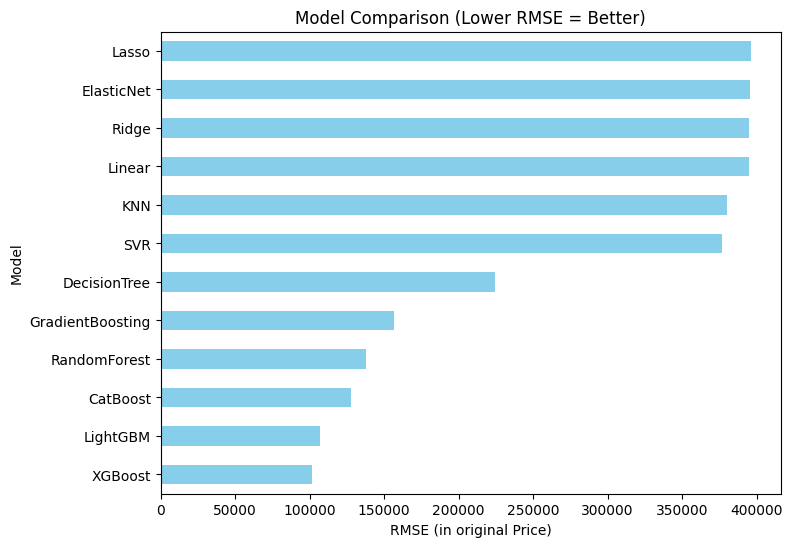

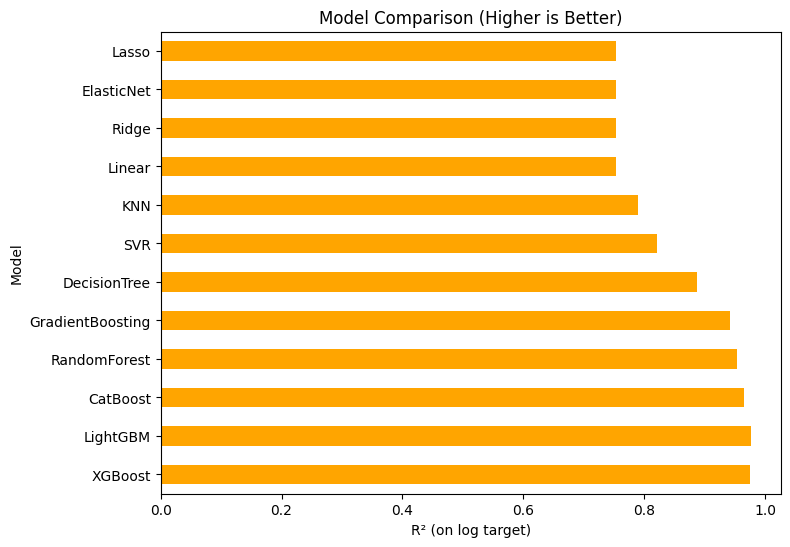

In [38]:
import matplotlib.pyplot as plt

# RMSE comparison
results_df.plot(x="Model", y="RMSE", kind="barh", figsize=(8,6), legend=False, color="skyblue")
plt.xlabel("RMSE (in original Price)")
plt.title("Model Comparison (Lower RMSE = Better)")
plt.show()

# R² comparison (on log target)
results_df.plot(x="Model", y="R2(log)", kind="barh", figsize=(8,6), legend=False, color="orange")
plt.xlabel("R² (on log target)")
plt.title("Model Comparison (Higher is Better)")
plt.show()


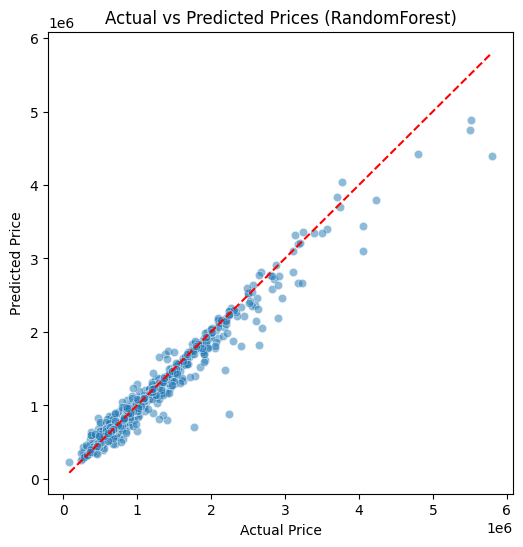

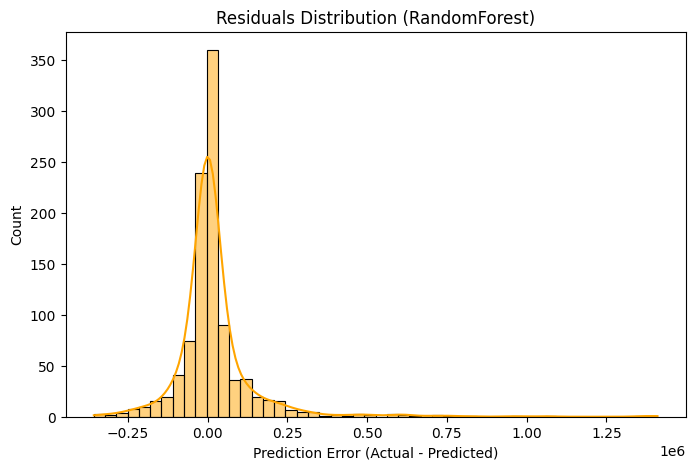

In [39]:
# Retrain best model (RandomForest in your case)
best_model = RandomForestRegressor(n_estimators=200, random_state=42)
best_model.fit(X_train, y_train_log)

# Predict and back-transform to Price
preds_log = best_model.predict(X_test)
preds = np.expm1(preds_log)       # predicted Price
y_true = np.expm1(y_test_log)     # actual Price

# Scatter plot Actual vs Predicted
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_true, y=preds, alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')  # perfect fit line
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Prices (RandomForest)")
plt.show()

# Residual distribution (errors)
residuals = y_true - preds
plt.figure(figsize=(8,5))
sns.histplot(residuals, bins=50, kde=True, color="orange")
plt.title("Residuals Distribution (RandomForest)")
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.show()


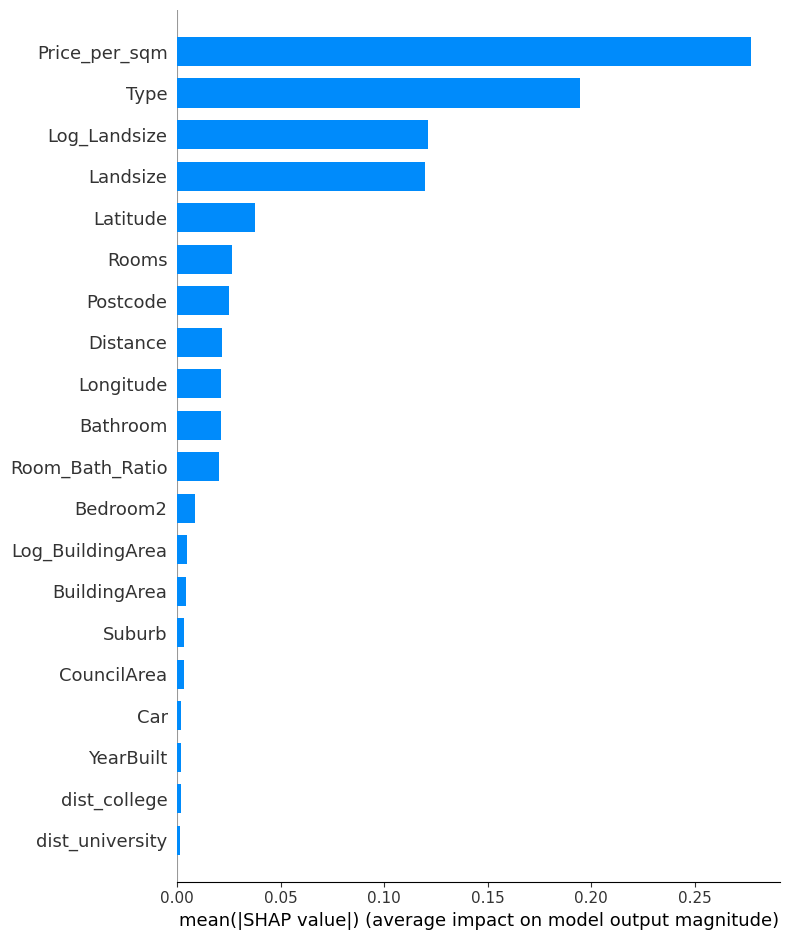

In [41]:
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# 1) Train RandomForest on LOG target
best_model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
best_model.fit(X_train, y_train_log)

# 2) SHAP explainer + values
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)   # shape: (n_samples, n_features)

# 3) Global feature importance (bar)
plt.figure()
shap.summary_plot(shap_values, X_test, plot_type="bar", show=True)

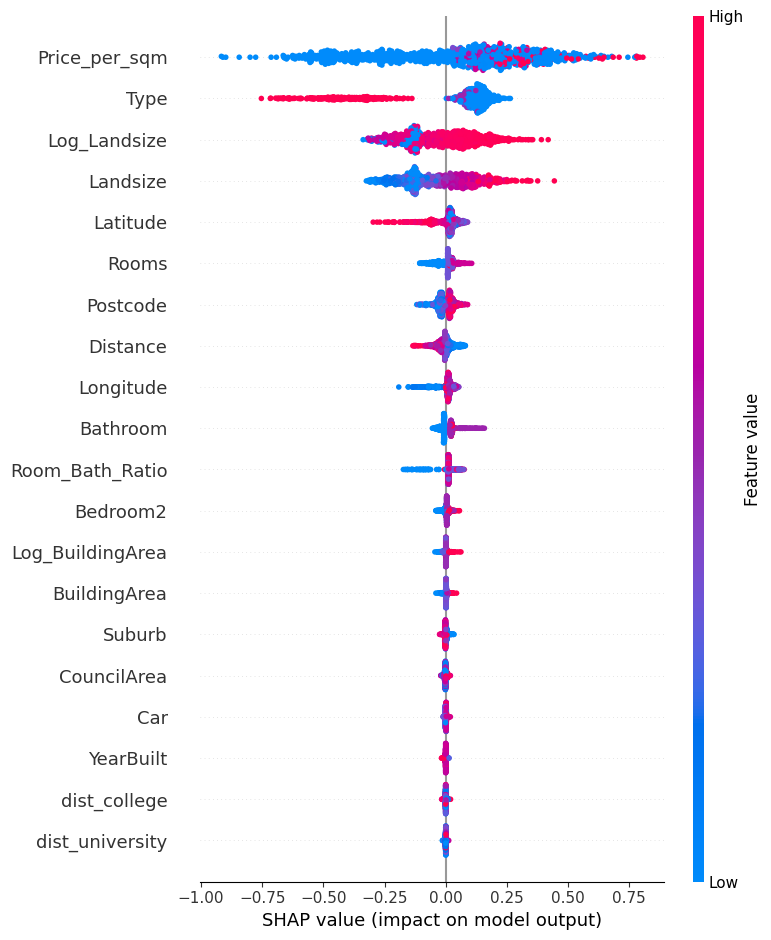

In [42]:
# 4) Detailed impact (beeswarm)
plt.figure()
shap.summary_plot(shap_values, X_test, show=True)


<Figure size 640x480 with 0 Axes>

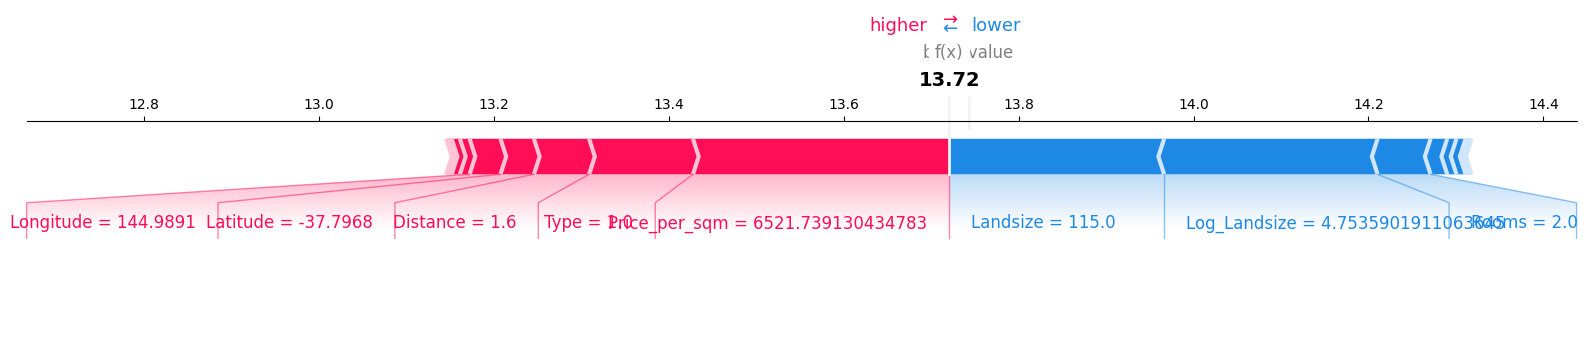

In [43]:
# 5) Explain a single prediction (first test row)
sample_idx = 0
plt.figure()
shap.force_plot(
    explainer.expected_value,
    shap_values[sample_idx, :],
    X_test.iloc[sample_idx, :],
    matplotlib=True
)